![image.png](https://i.imgur.com/a3uAqnb.png)


# **Day 2) ML Classification for Campus Placement.**

---
In this lab, you'll learn how to preprocess tabular data and implement:


1. **Logistic Regression** (from scratch)

2. **K-Nearest Neighbors**

3. **Support Vector Machine**

4. **Decision Tree Classifier**

5. **Random Forest Classifier**

6. **XGBoost Classifier**

7. **CatBoost Classifier**


---

# 📊 **Data**
https://www.kaggle.com/datasets/benroshan/factors-affecting-campus-placement

> This dataset contains information about campus recruitment factors. We'll predict whether a student will be placed or not (**binary classification**).


# 1️⃣ Import Libraries


In [ ]:
from IPython.display import clear_output

%pip install kagglehub catboost xgboost tqdm -q

clear_output()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
from tqdm import tqdm

%matplotlib inline

# 2️⃣ Read the Data


In [ ]:
# Download latest version
path = kagglehub.dataset_download("benroshan/factors-affecting-campus-placement")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'factors-affecting-campus-placement' dataset.
Path to dataset files: /kaggle/input/factors-affecting-campus-placement


In [ ]:
csv_path = os.path.join(path, "Placement_Data_Full_Class.csv")

df = pd.read_csv(csv_path)
df.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    object 
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
 13  status          215 non-null    object 
 14  salary          148 non-null    float64
dtypes: float64(6), int64(1), object(8)
memory usage: 25.3+ KB


# 3️⃣ Exploratory Data Analysis (EDA)

**Rule of thumb checklist:**

| Question | If YES | If NO |
|----------|--------|-------|
|  **Is the target imbalanced?** | Use F1/Precision/Recall + StratifiedKFold | Accuracy is fine + KFold |
|  **Missing values?** | Impute or drop | Proceed |
|  **Categorical columns?** | Encode them | Proceed |
|  **Duplicates?** | Drop them | Proceed |
|  **Different scales?** | Standardize (except tree models) | Proceed |


In [ ]:
# First, let's convert the target variable to numeric
# status: Placed = 1, Not Placed = 0
df['status'] = df['status'].map({'Placed': 1, 'Not Placed': 0})

# Drop unnecessary columns
df = df.drop(['salary', 'sl_no'], axis=1)
df.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,1
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,1
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,1
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,0
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,1


Target Distribution:
status
1    0.688372
0    0.311628
Name: proportion, dtype: float64


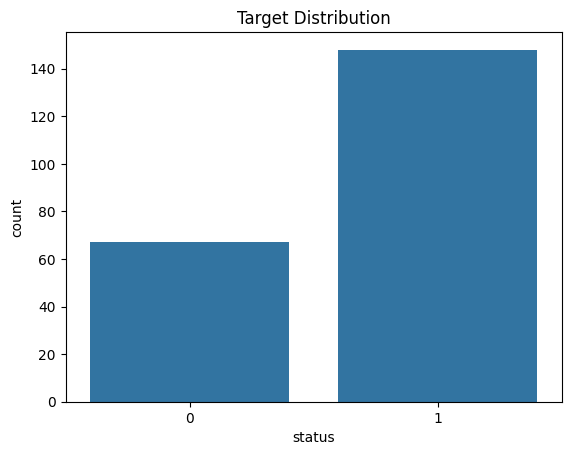

In [ ]:
# 1. Is the target imbalanced?
def check_target_imbalance(df, target_column):
  print("Target Distribution:")
  print(df[target_column].value_counts(normalize=True))
  sns.countplot(x=df[target_column])
  plt.title("Target Distribution")
  plt.show()

check_target_imbalance(df, "status")

> **Rule of thumb:** If class distributions are not equal, then our data is **imbalanced**. Use StratifiedKFold and focus on F1-score. And if data distribution is balanced, StratifiedKFold will act like regular KFold, so always use StratifiedKFold :)
>
> Here, roughly **68%** got placed, so there's an imbalance.


In [ ]:
# 2. Do we have missing values?
def check_missing_values(df):
  missing_values = df.isnull().sum()
  print("Missing Values per Column:")
  print(missing_values[missing_values > 0])
  if missing_values.any():
    print("\nHandle Missing Values as needed.")
  else:
    print("\nNo Missing Values Found.")

check_missing_values(df)

Missing Values per Column:
Series([], dtype: int64)

No Missing Values Found.


In [ ]:
# 3. Do we have categorical columns?
categorical_cols = df.select_dtypes(include=["object"]).columns

print("Categorical Columns:", list(categorical_cols))

Categorical Columns: ['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex', 'specialisation']


> We have categorical columns. We need to encode them (convert them into numbers) for our models.


**Label Encoding** converts each unique category into a number (0, 1, 2, ...).


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in categorical_cols:
  le = LabelEncoder()
  df[col] = le.fit_transform(df[col])
  label_encoders[col] = le

df

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
0,1,67.00,1,91.00,1,1,58.00,2,0,55.0,1,58.80,1
1,1,79.33,0,78.33,1,2,77.48,2,1,86.5,0,66.28,1
2,1,65.00,0,68.00,0,0,64.00,0,0,75.0,0,57.80,1
3,1,56.00,0,52.00,0,2,52.00,2,0,66.0,1,59.43,0
4,1,85.80,0,73.60,0,1,73.30,0,0,96.8,0,55.50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,1,80.60,1,82.00,1,1,77.60,0,0,91.0,0,74.49,1
211,1,58.00,1,60.00,1,2,72.00,2,0,74.0,0,53.62,1
212,1,67.00,1,67.00,1,1,73.00,0,1,59.0,0,69.72,1
213,0,74.00,1,66.00,1,1,58.00,0,0,70.0,1,60.23,1


In [ ]:
# 4. Do we have duplicate samples?
def check_duplicates(df):
  duplicates = df.duplicated().sum()
  print(f"Number of Duplicate Samples: {duplicates}")
  if duplicates > 0:
    print("Dropping Duplicates...")
    df.drop_duplicates(inplace=True)
    print("Duplicates Dropped.")
  else:
    print("No Duplicate Samples Found.")

check_duplicates(df)

Number of Duplicate Samples: 0
No Duplicate Samples Found.


> **Rule of thumb:** If duplicates exist, drop them with `df.drop_duplicates(inplace=True)`


In [ ]:
# 5. Do we have different scales in the data?
df.describe()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000
mean,0.646512,67.303395,0.460465,66.333163,0.609302,1.372093,66.370186,0.600000,0.344186,72.100558,0.441860,62.278186,0.688372
std,0.479168,10.827205,0.499598,10.897509,0.489045,0.580978,7.358743,0.890238,0.476211,13.275956,0.497767,5.833385,0.464240
min,0.000000,40.890000,0.000000,37.000000,0.000000,0.000000,50.000000,0.000000,0.000000,50.000000,0.000000,51.210000,0.000000
25%,0.000000,60.600000,0.000000,60.900000,0.000000,1.000000,61.000000,0.000000,0.000000,60.000000,0.000000,57.945000,0.000000
50%,1.000000,67.000000,0.000000,65.000000,1.000000,1.000000,66.000000,0.000000,0.000000,71.000000,0.000000,62.000000,1.000000
75%,1.000000,75.700000,1.000000,73.000000,1.000000,2.000000,72.000000,2.000000,1.000000,83.500000,1.000000,66.255000,1.000000
max,1.000000,89.400000,1.000000,97.700000,1.000000,2.000000,91.000000,2.000000,1.000000,98.000000,1.000000,77.890000,1.000000


> **Rule of thumb:** If features have vastly different ranges (e.g., percentages: 0-100, some binary: 0-1), then **scale them**.
>
> Tree models (RF, XGBoost) don't need scaling, but Logistic Regression, KNN, SVM do!


In [ ]:
from sklearn.preprocessing import StandardScaler

numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.drop("status")  # DON'T SCALE THE TARGET

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
df.head()


,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
0,0.739434,-0.028087,1.082459,2.268812,0.800763,-0.641955,-1.140102,1.576284,-0.724446,-1.291091,1.123903,-0.597647,1
1,0.739434,1.113369,-0.923823,1.103448,0.800763,1.083298,1.513267,1.576284,1.380364,1.087157,-0.889757,0.687620,1
2,0.739434,-0.213238,-0.923823,0.153313,-1.248809,-2.367207,-0.322843,-0.675550,-0.724446,0.218908,-0.889757,-0.769474,1
3,0.739434,-1.046417,-0.923823,-1.318339,-1.248809,1.083298,-1.957362,1.576284,-0.724446,-0.460592,1.123903,-0.489396,0
4,0.739434,1.712332,-0.923823,0.668391,-1.248809,-0.641955,0.943909,-0.675550,-0.724446,1.864806,-0.889757,-1.164676,1


# 4️⃣ Training our Classification Models

> We need to split our data into **X** (features) and **y** (target).


In [ ]:
X = df.drop("status", axis=1).astype(float)
y = df['status'].astype(float)

---

# Part A: Logistic Regression from Scratch

- **Sigmoid Function**

The **sigmoid** function "squashes" any input into the range [0, 1], making it perfect for probabilities:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

- **Binary Cross-Entropy Loss (Log Loss)**

We use **cross-entropy** to measure how well our predictions match the true labels:

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]$$

Where:
- $m$ = number of samples
- $y_i$ = true label (0 or 1)
- $\hat{y}_i$ = predicted probability (0 to 1)

> **Intuition:** If the true label is 1 and we predict 1, then no penalty. If we predict 0, then the penalty will be huge!

In [ ]:
# sigmoid in NumPy
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

In [ ]:
# BCE in NumPy
def binary_cross_entropy(y, y_hat):
  epsilon = 1e-15  # Very small number to prevent log(0)
  y_hat = np.clip(y_hat, epsilon, 1 - epsilon) # np.clip(value, min, max)

  loss = -1/len(y) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
  return loss

In [ ]:
def gradient_descent(X, y, learning_rate, n_iters=500):
  m, n = X.shape # m rows, n columns (dimensions)
  theta = np.zeros(n) # initialize a zeros weight vector with n dimensions
  losses = []

  for _ in tqdm(range(n_iters), desc="Training Logistic Regression"):
    z = np.dot(X, theta)
    y_hat = sigmoid(z)
    gradient = np.dot(X.T, (y_hat - y)) / m
    theta -= learning_rate * gradient

    loss = binary_cross_entropy(y, y_hat)
    losses.append(loss)

  return theta, losses

**Training Logistic Regression** using startified kfold

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
n_splits = 5 # K=5 Folds

# Stratified 5-Fold Cross-Validation, shuffled
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [ ]:
# Storage for logistic regression results for each fold
lr_losses = []
lr_accuracy = []
lr_precision = []
lr_recall = []
lr_f1 = []

In [ ]:
for fold_idx, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"\nFold {fold_idx + 1}/{n_splits}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train
    theta, losses = gradient_descent(X_train, y_train, learning_rate=0.5, n_iters=500)

    # Validate
    y_pred_proba = sigmoid(np.dot(X_test, theta))
    y_pred = (y_pred_proba >= 0.5).astype(int)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # Store results
    lr_losses.append(losses)
    lr_accuracy.append(accuracy)
    lr_precision.append(precision)
    lr_recall.append(recall)
    lr_f1.append(f1)


Fold 1/5


Training Logistic Regression: 100%|██████████| 500/500 [00:00<00:00, 908.88it/s]



Fold 2/5


Training Logistic Regression: 100%|██████████| 500/500 [00:00<00:00, 1042.06it/s]



Fold 3/5


Training Logistic Regression: 100%|██████████| 500/500 [00:00<00:00, 700.82it/s]



Fold 4/5


Training Logistic Regression: 100%|██████████| 500/500 [00:01<00:00, 498.53it/s]



Fold 5/5


Training Logistic Regression: 100%|██████████| 500/500 [00:01<00:00, 412.22it/s]


**Logistic Regression Loss Curve**

> use `np.mean(..)` to get the average across all folds.


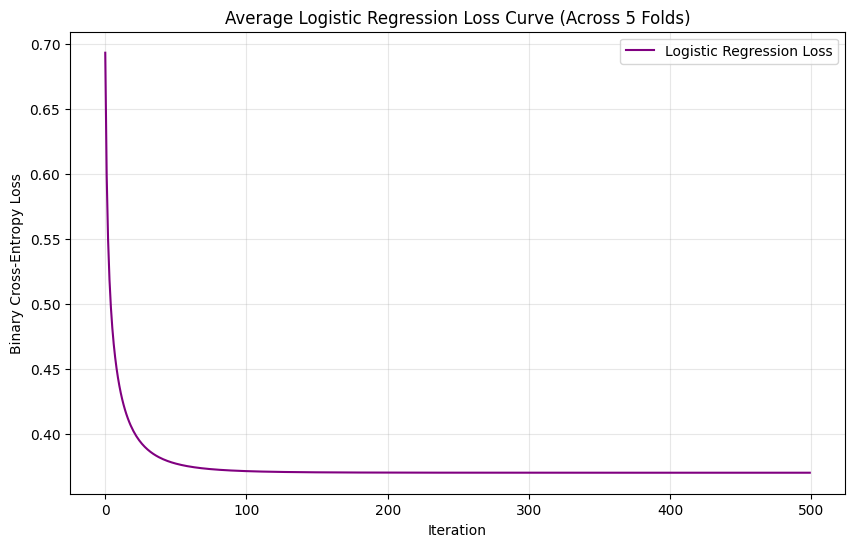

In [ ]:
# Calculate average loss across folds
avg_loss = np.mean(lr_losses, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(avg_loss, label='Logistic Regression Loss', color='purple')
plt.title('Average Logistic Regression Loss Curve (Across 5 Folds)')
plt.xlabel('Iteration')
plt.ylabel('Binary Cross-Entropy Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Logistic Regression Results**

> use `np.mean(..)` to get the average across all folds.



In [ ]:
print("LOGISTIC REGRESSION Performance:")
print(f"  Accuracy:  {np.mean(lr_accuracy):.4f}")
print(f"  Precision: {np.mean(lr_precision):.4f}")
print(f"  Recall:    {np.mean(lr_recall):.4f}")
print(f"  F1-Score:  {np.mean(lr_f1):.4f}")

LOGISTIC REGRESSION Performance:
  Accuracy:  0.7907
  Precision: 0.9549
  Recall:    0.7299
  F1-Score:  0.8267


---

# Part B: Sklearn Classification Models


In [ ]:
# Import models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

**Define models with their hyperparameters**

In [ ]:
sklearn_models = {
  "K-Nearest Neighbors": KNeighborsClassifier(
      n_neighbors=3,  # Number of neighbors to consider
  ),
  "Support Vector Machine": SVC(
      kernel='rbf',  # 'linear', 'poly', 'rbf', 'sigmoid'
      C=0.75  # Regularization parameter
  ),
  "Decision Tree": DecisionTreeClassifier(
      max_depth=3  # Maximum depth of tree (prevents overfitting)
  ),
  "Random Forest": RandomForestClassifier(
      n_estimators=320,  # Number of trees
      max_depth=4
  ),
  "XGBoost": XGBClassifier(
      verbosity=0,
      n_estimators=300,  # Number of boosting rounds
      max_depth=5,
      learning_rate=0.05 # Step size shrinkage
  ),
  "CatBoost": CatBoostClassifier(
      verbose=0,
      n_estimators=320,
      max_depth=4
  )
}

**Storage for all metrics per model:** so we can inspect them after training

In [ ]:
all_results = {}

for name in sklearn_models:
  all_results[name] = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

**Training Sklearn Models with Cross-Validation**

In [ ]:
n_splits = 5 # K

# Stratified 5-Fold Cross-Validation, shuffled
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [ ]:
for fold_idx, (train_index, test_index) in enumerate(skf.split(X, y)):
  print(f"\nFold {fold_idx + 1}/{n_splits}")

  # 1. Split data
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # 2. Train & Validate sklearn models
  for model_name, model in sklearn_models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train) # train
    y_pred = model.predict(X_test) # validate

    # 3. Save metrics for that model in this fold
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    all_results[model_name]['accuracy'].append(accuracy)
    all_results[model_name]['precision'].append(precision)
    all_results[model_name]['recall'].append(recall)
    all_results[model_name]['f1'].append(f1)


Fold 1/5
Training K-Nearest Neighbors...
Training Support Vector Machine...
Training Decision Tree...
Training Random Forest...
Training XGBoost...
Training CatBoost...

Fold 2/5
Training K-Nearest Neighbors...
Training Support Vector Machine...
Training Decision Tree...
Training Random Forest...
Training XGBoost...
Training CatBoost...

Fold 3/5
Training K-Nearest Neighbors...
Training Support Vector Machine...
Training Decision Tree...
Training Random Forest...
Training XGBoost...
Training CatBoost...

Fold 4/5
Training K-Nearest Neighbors...
Training Support Vector Machine...
Training Decision Tree...
Training Random Forest...
Training XGBoost...
Training CatBoost...

Fold 5/5
Training K-Nearest Neighbors...
Training Support Vector Machine...
Training Decision Tree...
Training Random Forest...
Training XGBoost...
Training CatBoost...


**Sklearn Models Performance**

> again, use `np.mean(..)` to get the average across all folds :p

In [ ]:
for model_name in all_results:
  print(f"\n{model_name}:")
  print(f"  Accuracy:  {np.mean(all_results[model_name]['accuracy']):.4f}")
  print(f"  Precision: {np.mean(all_results[model_name]['precision']):.4f}")
  print(f"  Recall:    {np.mean(all_results[model_name]['recall']):.4f}")
  print(f"  F1-Score:  {np.mean(all_results[model_name]['f1']):.4f}")


K-Nearest Neighbors:
  Accuracy:  0.8186
  Precision: 0.8576
  Recall:    0.8848
  F1-Score:  0.8700

Support Vector Machine:
  Accuracy:  0.8744
  Precision: 0.8729
  Recall:    0.9598
  F1-Score:  0.9132

Decision Tree:
  Accuracy:  0.8233
  Precision: 0.8207
  Recall:    0.9529
  F1-Score:  0.8814

Random Forest:
  Accuracy:  0.8605
  Precision: 0.8470
  Recall:    0.9729
  F1-Score:  0.9054

XGBoost:
  Accuracy:  0.8744
  Precision: 0.9035
  Recall:    0.9189
  F1-Score:  0.9100

CatBoost:
  Accuracy:  0.8698
  Precision: 0.8761
  Recall:    0.9460
  F1-Score:  0.9092


---

## Are our models good?

If the dataset is imbalanced, a model can look "good" by mostly predicting the majority class.

> **Baseline:** always predict the majority class.

In [ ]:
# Calculate the majority class baseline
majority_class = y.value_counts().idxmax()
baseline_pred = [majority_class] * len(y)

# Evaluate the baseline
baseline_accuracy = accuracy_score(y, baseline_pred)
baseline_precision = precision_score(y, baseline_pred, average='weighted', zero_division=0)
baseline_recall = recall_score(y, baseline_pred, average='weighted', zero_division=0)
baseline_f1 = f1_score(y, baseline_pred, average='weighted', zero_division=0)

print(f"Baseline Accuracy (majority class): {baseline_accuracy:.4f}")
print(f"Baseline Precision: {baseline_precision:.4f}")
print(f"Baseline Recall: {baseline_recall:.4f}")
print(f"Baseline F1-Score: {baseline_f1:.4f}")


Baseline Accuracy (majority class): 0.6884
Baseline Precision: 0.4739
Baseline Recall: 0.6884
Baseline F1-Score: 0.5613


> **Our models are way better than this baseline!**


---

## Sklearn Models Feature Importance

> Tree-based models provide built-in feature importance scores.


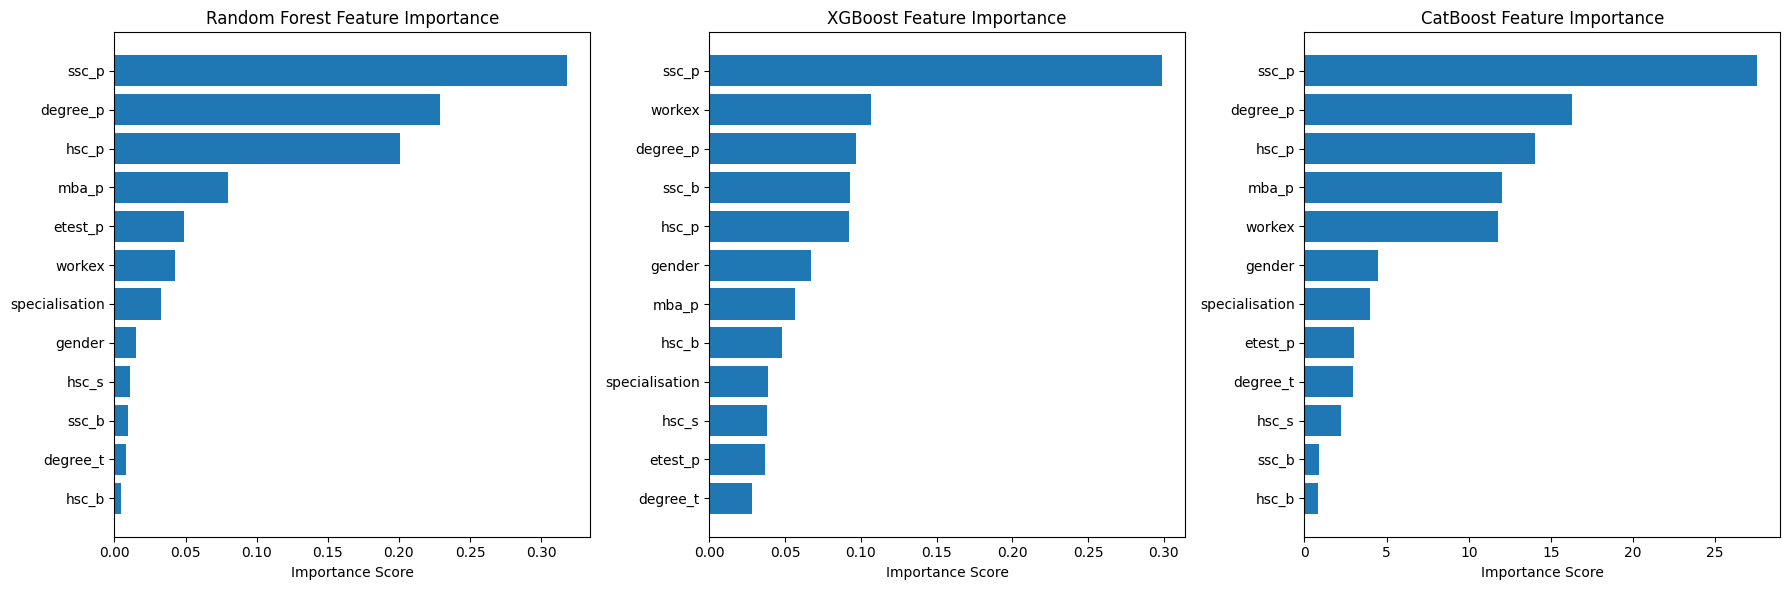

In [ ]:
# Gather importances from the models (from the last fold)
importances = {}

importances['Random Forest'] = sklearn_models['Random Forest'].feature_importances_
importances['XGBoost'] = sklearn_models['XGBoost'].feature_importances_
importances['CatBoost'] = sklearn_models['CatBoost'].feature_importances_

# Create a 1x3 plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.flatten()
features = X.columns

for i, (model_name, imp) in enumerate(importances.items()):
  # Sort features by importance for a cleaner plot
  sorted_idx = np.argsort(imp)

  ax = axes[i]
  ax.barh(features[sorted_idx], imp[sorted_idx])
  ax.set_title(f"{model_name} Feature Importance")
  ax.set_xlabel("Importance Score")

plt.tight_layout()
plt.show()

# Final Notes

- **Tree-based models** (XGBoost, CatBoost, Random Forest) often perform best on tabular data
- **Want to improve?** Try ensembling, feature engineering, and hyperparameter tuning!

For more info visit sklearn docs for each algorithm:
- [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
- [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)
- [CatBoost](https://catboost.ai/docs/en/concepts/python-reference_catboostclassifier)


### **Contribution: Sattam Altwaim** :)

![image.png](https://i.imgur.com/EloTazu.jpeg)
